In [1]:
import numpy as np   
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.atlas import *
from networkx.algorithms.isomorphism.isomorph import graph_could_be_isomorphic as isomorphic
import random

#EPIDEMIC ON NETWORKS 
#https://epidemicsonnetworks.readthedocs.io/en/latest/GettingStarted.html
#FROM the book 
#Mathematics of Epidemics on Networks: from Exact to Approximate Models
#István Z. Kiss, Joel C. Miller, Péter L. Simon
#Springer Link

#Install EON
#pip install EoN
import EoN

In [7]:
def SIR_net(G, beta, mu, initial_infecteds):

    '''
    INPUT 
    G : a network
    beta : transmission per link
    mu : recovery rate
    initial_infecteds : node or iterable of nodes that will be infected at the beginning 
    
    OUTPUT
    t,S,I,R numpy arrays with series of time steps, and series of number of infected, susceptible, recovered
    G.number_of_nodes() : to get the number of nodes
    nx.set_node_attributes(G,dictionary_node_attribute, 'attribute_name'): nodes have as attribute attribute_name
    G.node[i]['attribute']= attibute_value : set attribute of node i to attribute_value
    nx.nodes(G) : iterable on nodes
    nx.all_neighbors(G, i) : iterable on nodes neighbors of i
    '''  

    nx.set_node_attributes(G, 'S', 'state')
    nx.set_node_attributes(G, 'S', 'new_state')
    if isinstance(initial_infecteds, int):
        G.nodes[initial_infecteds]['state']='I'
    else:
        for i in initial_infecteds:
            G.nodes[i]['state']='I'
    
    ts=0
    S_count = sum(1 for u in G if G.nodes[u]["state"] == "S")
    I_count = sum(1 for u in G if G.nodes[u]["state"] == "I")
    R_count = sum(1 for u in G if G.nodes[u]["state"] == "R")

    t=[ts,]
    S=[S_count,]
    I=[I_count,]
    R=[R_count,]

    while I_count>0:

        for i in nx.nodes(G):
            G.nodes[i]['new_state']=G.nodes[i]['state']      #reset new state attribute

        for i in nx.nodes(G):
            if G.nodes[i]['state']=='I':
                for j in nx.all_neighbors(G,i):
                    if G.nodes[j]['state']=='S':
                        if random.random() < beta:
                            G.nodes[j]['new_state']='I'
                if random.random() < mu:
                    G.nodes[i]['new_state']='R'
                    
        for i in nx.nodes(G):
            G.nodes[i]['state']=G.nodes[i]['new_state']      #update

        ts+=1
        S_count = sum(1 for u in G if G.nodes[u]["state"] == "S")
        I_count = sum(1 for u in G if G.nodes[u]["state"] == "I")
        R_count = sum(1 for u in G if G.nodes[u]["state"] == "R")

        t.append(ts)
        S.append(S_count)
        I.append(I_count)
        R.append(R_count)

    return t, S, I, R



In [3]:
N= 1000 #number of nodes 

#GENERATE AN ER GRAPH
p= 0.004  #edge probability
ERG= nx.erdos_renyi_graph(N, p)
print("ER")
print("number of edges", len(ERG.edges()))
print("first moment", np.mean([d for i,d in ERG.degree]))
print("second moment", np.mean([d*d for i,d in ERG.degree]))

#GENERATE A BA GRAPH
m=2 #number of links for the preferential attachment
BAG= nx.barabasi_albert_graph(N, m)
print("BA")
print("number of edges", len(BAG.edges()))
print("first moment", np.mean([d for i,d in BAG.degree]))
print("second moment", np.mean([d*d for i,d in BAG.degree]))


ER
number of edges 1999
first moment 3.998
second moment 20.012
BA
number of edges 1996
first moment 3.992
second moment 39.258


ER, beta 0.00025
BA, beta 0.00025
ER, beta 0.0005
BA, beta 0.0005
ER, beta 0.00075
BA, beta 0.00075
ER, beta 0.001
BA, beta 0.001
ER, beta 0.0025
BA, beta 0.0025
ER, beta 0.005
BA, beta 0.005
ER, beta 0.0075
BA, beta 0.0075
ER, beta 0.01
BA, beta 0.01
ER, beta 0.02
BA, beta 0.02
ER, beta 0.03
BA, beta 0.03
ER, beta 0.04
BA, beta 0.04
ER, beta 0.05
BA, beta 0.05
ER, beta 0.06
BA, beta 0.06
ER, beta 0.1
BA, beta 0.1
ER, beta 0.2
BA, beta 0.2
ER, beta 0.3
BA, beta 0.3
ER, beta 0.4
BA, beta 0.4


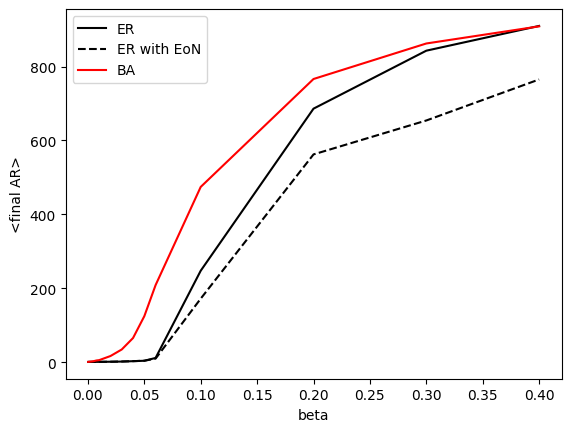

In [12]:
Nrun= 200
#Nrun=10
mu= 0.2 # recovery probability

AR_ER=[]
AR_BA=[]
AR_EReon=[]
AR_BAeon=[]

#List of beta values
explored_beta= [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
               0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3, 0.4]
#explored_beta= [0.01, 0.1]

for beta in explored_beta:
    #SPREADING ON THE ER NETWORK
    print("ER, beta", beta)
    final_AR=[]
    final_AReon=[]
    for n in range(Nrun):
        teon, Seon, Ieon, Reon = EoN.fast_SIR(ERG, beta, mu, initial_infecteds=0)
        t, S, I, R = SIR_net(ERG, beta, mu, initial_infecteds=1) #YOUR ROUTINE !
        tfinal= len(t)-1
        tfinaleon= len(teon)-1
        final_AR.append(R[tfinal]) #compute the final number of infected nodes
        final_AReon.append(Reon[tfinaleon]) #compute the final number of infected nodes
    AR_ER.append(float(sum(final_AR))/len(final_AR))        #average ok final attack rate
    AR_EReon.append(float(sum(final_AReon))/len(final_AReon))        #average ok final attack rate
    
    #SPREADING ON THE BA NETWORK
    print("BA, beta", beta)
    final_AR=[]
    for n in range(Nrun):
        t, S, I, R = EoN.fast_SIR(BAG, beta, mu, initial_infecteds=0)
        tfinal= len(t)-1
        final_AR.append(R[tfinal])
    AR_BA.append(float(sum(final_AR))/len(final_AR))

   
plt.figure()
plt.plot(explored_beta, AR_ER, color='black', label='ER')
plt.plot(explored_beta, AR_EReon, '--', color='black', label='ER with EoN')
plt.plot(explored_beta, AR_BA, color='red', label='BA')
plt.xlabel("beta")
plt.ylabel("<final AR>")
plt.legend()
plt.show()
plt.close() 


Erdos Renyi has bigger epidemic threshold